In [104]:
import numpy as np
import pandas as pd
import re
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

Importing data

In [106]:
df = pd.read_csv('main_data.csv')  

In [107]:
df['DATE'] = pd.to_datetime(
                          df['DATE'],
                          format='%Y-%m-%d')

In [108]:
df = df.sort_values(by="DATE")

In [109]:
# replace -1 with nan in Returns columns
cols = ["1MReturn","3MReturn","6MReturn","12MReturn"]
df[cols] = df[cols].replace({'-1':np.nan, -1:np.nan})

How many stocks dont have any ratings

In [111]:
is_all_null_per_stock = df.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().all()).to_frame()
all_null_per_stock_count = is_all_null_per_stock['SCORE'].value_counts().to_frame()
all_null_per_stock_count.reset_index(inplace=True)
all_null_per_stock_count.columns = ['VALUE', 'COUNT']

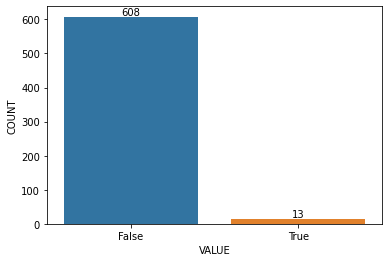

In [112]:
ax = sns.barplot(x='VALUE', y='COUNT', data=all_null_per_stock_count)
ax.bar_label(ax.containers[0])
plt.show()

Companies whitout any ratings can be deleted. There is nothing more to analyze

In [113]:
companies_without_scores = is_all_null_per_stock.loc[is_all_null_per_stock['SCORE'] == True]
companies_without_scores.reset_index(inplace=True)
companies_without_score = companies_without_scores['STOCK'].to_list()

In [114]:
df = df[~df['STOCK'].isin(companies_without_score)]

How many Stocks have at least one missing score?

In [115]:
is_any_null_per_stock = df.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().any()).to_frame()

In [116]:
any_null_per_stock_count = is_any_null_per_stock['SCORE'].value_counts().to_frame()
any_null_per_stock_count.reset_index(inplace=True)
any_null_per_stock_count.columns = ['VALUE', 'COUNT']

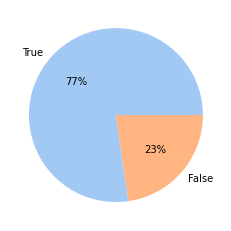

In [117]:
plt.pie(any_null_per_stock_count['COUNT'], labels = any_null_per_stock_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()

Almost 80 percent of companies have at least one measing value when it comes to score

Which Percent of Returns are missing

In [118]:
percent_missing = df[cols].isnull().sum() * 100 / len(df)

In [119]:
percent_missing

1MReturn     0.163399
3MReturn     0.113669
6MReturn     0.099460
12MReturn    4.440182
dtype: float64